**Ecuación de Black - Scholes**

Abordaremos la resolución de la siguiente SDE correspondiente al modelo de Black - Scholes:

$$
dS_t = \mu S_t dt + \sigma S_t dW_t
$$

Donde:

- $S_t$: Representa el valor de un activo (por ejemplo, una acción) en el tiempo \( t \).

- $\mu$: Es la tasa de crecimiento esperada del activo (también conocida como el "drift"), que refleja el comportamiento determinista de la acción.

- $\sigma$: Es la volatilidad del activo, que mide la incertidumbre o el "ruido" asociado con los cambios en el valor del activo.

- $dW_t$: Es el incremento del proceso de Wiener (también llamado movimiento browniano), que representa la parte aleatoria del cambio de $S_t$. Este proceso es fundamental para modelar la incertidumbre o la aleatoriedad en el precio del activo.



Para modelar el proceo de Weiner usamos el teorema de Kosambi–Karhunen–Loève:

$$
W_t = \sqrt{2} \sum_{k=1}^{\infty} \zeta_k \frac{\sin\left( \left(k - \frac{1}{2}\right) \pi t \right)}{(k - \frac{1}{2}) \pi}

$$

donde las $\zeta_k$ son variables aleatorias i.i.d. normales $N(0,1)$.

Hacemos la aproximación:

$$
W_t \thickapprox  \sqrt{2} \sum_{k=1}^{n} \zeta_k \frac{\sin\left( \left(k - \frac{1}{2}\right) \pi t \right)}{(k - \frac{1}{2}) \pi}
$$



Trabajaremos con la siguiente función de pérdida:

$$
\mathcal{L}(u,f)=\sum_t \left\| \frac{\partial u}{\partial t} - f(u,t) - g(u,t) \frac{\partial W(t, \zeta_1, \dots, \zeta_n)}{\partial t} \right\|
$$

Donde a partir de la aproximación para $W_t$ obtenemos:

$$
\frac{\partial W(t, \zeta_1, \dots, \zeta_n)}{\partial t} = \sqrt{2} \sum_{k=1}^{n} \zeta_k \cos \left( \left( k - \frac{1}{2} \right) \pi t \right)
$$



In [ ]:
import math
from time import perf_counter as timer

# Pytorch
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

# Numpy
import numpy as np

# Matplotlib
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation

# Plotly
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import plotly.offline as pyo


# Pandas
import pandas as pd


from tqdm import tqdm
 

# Semilla aleatoria
seed = 42

# Fijamos la semilla para Pytorch y Numpy
torch.manual_seed(seed)
np.random.seed(seed)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
     

In [2]:
def dWdt_kl_torch(t, zetas, T):
    """
    Derivada temporal aproximada dW/dt usando KL.

    t:     (N,1)
    zetas: (N,n_terms)  (cada fila es un vector ζ distinto)
    T:     escalar torch
    """
    N, n_terms = zetas.shape
    device = t.device
    dtype  = t.dtype

    k = torch.arange(1, n_terms + 1, device=device, dtype=dtype).view(1, -1)  # (1,n)

    t_hat = t / T                         # (N,1)
    arg = (k - 0.5) * math.pi * t_hat     # (N,n)
    cos_term = torch.cos(arg)             # (N,n)

    sum_term = (zetas * cos_term).sum(dim=1, keepdim=True)  # (N,1)

    factor = math.sqrt(2.0 / float(T))
    return factor * sum_term             # (N,1)


In [3]:
class LogSPINN(nn.Module):
    """
    PINN que aproxima u(t, ζ) = log(S(t,ζ)/S0).
    Luego S(t,ζ) = S0 * exp(u).
    """
    def __init__(self, T, n_terms, hidden_dim=64, n_hidden=3):
        super().__init__()
        self.T  = T
        self.n_terms = n_terms

        in_dim = 1 + n_terms  # t + ζ
        out_dim = 1           # u(t,ζ)

        layers = [nn.Linear(in_dim, hidden_dim), nn.Tanh()]
        for _ in range(n_hidden - 1):
            layers += [nn.Linear(hidden_dim, hidden_dim), nn.Tanh()]
        layers += [nn.Linear(hidden_dim, out_dim)]
        self.net = nn.Sequential(*layers)

    def forward(self, t, zetas):
        """
        t:     (N,1)
        zetas: (N,n_terms)
        """
        t_norm = t / self.T
        x = torch.cat([t_norm, zetas], dim=1)
        u_theta = self.net(x)  # (N,1)
        return u_theta


In [ ]:
def residual_pde_logS(model, t, zetas, mu, sigma, T):
    """
    PDE para u(t,ζ) = log(S(t,ζ)/S0)
    u_t = (mu - 0.5*sigma^2) + sigma * dW/dt.
    """
    t_req = t.clone().detach().requires_grad_(True)
    z_req = zetas.clone().detach()

    u_pred = model(t_req, z_req)  # (N,1)

    du_dt = torch.autograd.grad(
        u_pred,
        t_req,
        grad_outputs=torch.ones_like(u_pred),
        create_graph=True
    )[0]  # (N,1)

    dWdt = dWdt_kl_torch(t_req, z_req, T)  # (N,1)

    rhs = (mu - 0.5 * sigma**2) + sigma * dWdt
    
    res = du_dt - rhs
    return res, u_pred, t_req

In [5]:
def pinn_loss_logS(model, mu, sigma, T, n_terms,
                   N_colloc=1024, N_ic=128, device="cpu"):

    # 1) Colocación en (t, ζ)
    t_colloc = torch.rand(N_colloc, 1, device=device) * T
    z_colloc = torch.randn(N_colloc, n_terms, device=device)

    res, u_pred, _ = residual_pde_logS(model, t_colloc, z_colloc, mu, sigma, T)
    loss_pde = torch.mean(res**2)

    # 2) Condición inicial u(0,ζ) = 0
    t_ic = torch.zeros(N_ic, 1, device=device)
    z_ic = torch.randn(N_ic, n_terms, device=device)

    u0_pred = model(t_ic, z_ic)
    loss_ic = torch.mean(u0_pred**2)  # (u(0) - 0)^2

    return loss_pde + loss_ic, loss_pde.detach(), loss_ic.detach()


In [ ]:
# Parámetros del problema
S0_val   = 100.0
mu_val   = 0.05
sigma_val= 0.2
T_val    = 1.0
n_terms  = 20

mu_t    = torch.tensor(mu_val,    dtype=torch.float32, device=device)
sigma_t = torch.tensor(sigma_val, dtype=torch.float32, device=device)
T_t     = torch.tensor(T_val,     dtype=torch.float32, device=device)
S0_t    = torch.tensor(S0_val,    dtype=torch.float32, device=device)

model = LogSPINN(T_t, n_terms, hidden_dim=128, n_hidden=5).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

n_epochs = 5000

for epoch in range(1, n_epochs + 1):
    optimizer.zero_grad()
    loss, loss_pde, loss_ic = pinn_loss_logS(
        model,
        mu_t, sigma_t, T_t,
        n_terms,
        N_colloc=1024,
        N_ic=128,
        device=device
    )
    loss.backward()
    optimizer.step()

    if epoch % 500 == 0:
        print(f"Epoch {epoch:5d} | total={loss.item():.4e} | pde={loss_pde.item():.4e} | ic={loss_ic.item():.4e}")


Epoch   500 | total=6.0448e-01 | pde=6.0243e-01 | ic=2.0427e-03
Epoch  1000 | total=4.5147e-01 | pde=4.4998e-01 | ic=1.4944e-03
Epoch  1500 | total=2.9817e-01 | pde=2.9779e-01 | ic=3.8511e-04
Epoch  2000 | total=1.8265e-01 | pde=1.8228e-01 | ic=3.7037e-04
Epoch  2500 | total=1.2616e-01 | pde=1.2598e-01 | ic=1.7521e-04
Epoch  3000 | total=1.0657e-01 | pde=1.0646e-01 | ic=1.1440e-04
Epoch  3500 | total=6.3440e-02 | pde=6.3278e-02 | ic=1.6139e-04
Epoch  4000 | total=5.6150e-02 | pde=5.5899e-02 | ic=2.5109e-04
Epoch  4500 | total=3.2266e-02 | pde=3.2077e-02 | ic=1.8980e-04
Epoch  5000 | total=2.9547e-02 | pde=2.9351e-02 | ic=1.9553e-04


In [7]:
import math
import torch

def W_kl_torch(t, zetas, T):
    """
    Aproxima W(t, ζ) con la misma KL que deriva tu dWdt_kl_torch.
    t:     (N,1)
    zetas: (N,n_terms)  (mismas ζ que van al modelo)
    T:     escalar torch
    """
    N, n_terms = zetas.shape
    device = t.device
    dtype  = t.dtype

    k = torch.arange(1, n_terms + 1, device=device, dtype=dtype).view(1, -1)  # (1,n)

    t_hat = t / T                        # (N,1)
    arg = (k - 0.5) * math.pi * t_hat    # (N,n)
    sin_term = torch.sin(arg)            # (N,n)

    # coeficientes de la KL
    coeff = math.sqrt(2.0 * float(T)) / ((k - 0.5) * math.pi)  # (1,n)

    # sum_k ζ_k * coeff_k * sin(...)
    W = (zetas * coeff * sin_term).sum(dim=1, keepdim=True)    # (N,1)
    return W


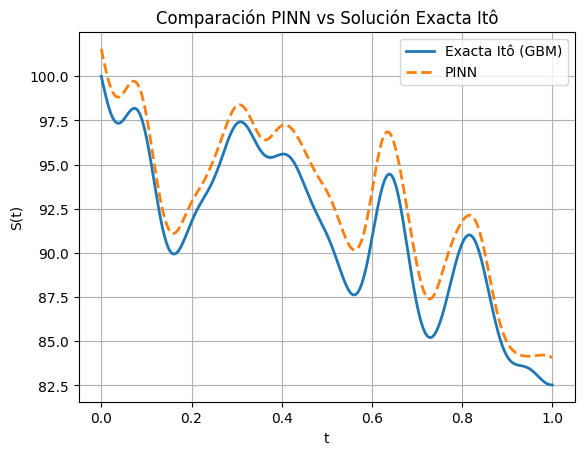

Max |S_pinn - S_exact|: 2.7384262


In [ ]:
import matplotlib.pyplot as plt
import numpy as np

model.eval()

n_t = 200
t_plot = torch.linspace(0, T_val, n_t, device=device).view(-1, 1)  # (n_t,1)

# Fijamos una realización de ζ
z_single = torch.randn(1, n_terms, device=device)  # (1,n_terms)
z = z_single.repeat(n_t, 1)                        # (n_t, n_terms)



with torch.no_grad():
    u_pinn = model(t_plot, z)          # (n_t,1)
    S_pinn = S0_t * torch.exp(u_pinn)  # reconstruimos S


W = W_kl_torch(t_plot, z, T_t)         # (n_t,1)


# La solución exacta de BS es: S(t) = S0 * exp((mu - 0.5*sigma^2)t + sigma*W(t))
u_exact = (mu_t - 0.5 * sigma_t**2) * t_plot + sigma_t * W 

S_exact = S0_t * torch.exp(u_exact)    # S(t) = S0 * exp(u)

# Pasamos a numpy
t_np       = t_plot.cpu().numpy().ravel()
S_pinn_np = S_pinn.cpu().numpy().ravel()
S_exact_np = S_exact.cpu().numpy().ravel()

# Gráfico
plt.figure()
plt.plot(t_np, S_exact_np, label="Exacta Itô (GBM)", linewidth=2)
plt.plot(t_np, S_pinn_np, "--", label="PINN", linewidth=2)
plt.xlabel("t")
plt.ylabel("S(t)")
plt.title("Comparación PINN vs Solución Exacta Itô")
plt.legend()
plt.grid(True)
plt.show()

# Métricas de error
abs_diff = np.abs(S_pinn_np - S_exact_np)
print("Max |S_pinn - S_exact|:", abs_diff.max())

**Ahora adaptamos el código para entrenar con datos:**

In [ ]:
class BlackScholesKL:
    """
    Clase para generar datos sintéticos de la SDE de Black–Scholes
    usando la expansión de Karhunen–Loève del Wiener.
    """

    def __init__(self, S0, mu, sigma, T, n_terms=20):
        """
        S0: precio inicial
        mu: drift
        sigma: volatilidad
        T: horizonte temporal
        n_terms: términos truncados de KL
        """
        self.S0 = S0
        self.mu = mu
        self.sigma = sigma
        self.T = T
        self.n_terms = n_terms
        self.zetas = np.random.normal(0, 1, size=self.n_terms).astype(np.float32)

    # -------------------
    # 2) Expansión KL de W(t)
    # -------------------
    def W_kl(self, t):
        """
        t: escalar o array de tiempos en [0, T]
        Retorna la aproximación KL del proceso de Wiener W(t).
        """

        t = np.array(t, ndmin=1)
        t_hat = t / self.T

        k = np.arange(1, self.n_terms + 1)
        numer = np.sin((k - 0.5) * np.pi * t_hat[:, None])
        denom = (k - 0.5) * np.pi

        W = np.sqrt(2 * self.T) * np.sum(self.zetas[None, :] * numer / denom, axis=1)
        return W

    # -----------------------------
    # 3) Derivada de W(t)
    # -----------------------------
    def dWdt_kl(self, t):
        """
        Derivada temporal de la expansión KL del Wiener.
        (Se usa para el loss de la PINN)
        """

        t = np.array(t, ndmin=1)
        t_hat = t / self.T

        k = np.arange(1, self.n_terms + 1)
        arg = (k - 0.5) * np.pi * t_hat[:, None]

        dWdt = np.sqrt(2.0 / self.T) * np.sum(self.zetas[None, :] * np.cos(arg), axis=1)
        return dWdt

    # -----------------------------
    # 4) Simulación con Euler–Maruyama
    # -----------------------------
    def simulate_path(self, N=200):
        """
        Simula una trayectoria S(t) de Black–Scholes usando KL
        y Euler–Maruyama estándar:

            dS = mu*S*dt + sigma*S*dW

        donde dW se toma como incrementos de W_kl(t).
        """

        t = np.linspace(0, self.T, N)
        dt = t[1] - t[0]

        # Wiener aproximado en la malla
        W = self.W_kl(t)
        dW = np.diff(W)  # incrementos W_{i+1} - W_i

        S = np.zeros(N)
        S[0] = self.S0

        for i in range(N - 1):
            dS = self.mu * S[i] * dt + self.sigma * S[i] * dW[i]
            S[i + 1] = S[i] + dS

        # También calculamos dWdt por si quieres usarlo aparte
        dWdt = self.dWdt_kl(t)

        return t, S, dWdt

    # -------------------
    # 5) Dataset completo para PINN
    # -------------------
    def generate_dataset(self, N=200):
        """
        Devuelve un dataset con:
        - t: tiempos
        - S(t): trayectoria simulada (Euler–Maruyama con W_kl)
        - W(t): Wiener KL
        - dW/dt: derivada KL

        Ideal para entrenar una PINN del estilo del paper.
        """
        t = np.linspace(0, self.T, N)
        W = self.W_kl(t)
        dWdt = self.dWdt_kl(t)

        # Simulación del precio (usa EM con incrementos de W_kl)
        _, S, _ = self.simulate_path(N)

        return {
            "t": t,
            "S": S,
            "W": W,
            "dWdt": dWdt,
            "zetas": self.zetas
        }


In [10]:
def generate_logS_data_from_KL(S0, mu, sigma, T, n_terms, N_time=200, N_paths=10):
    """
    Genera datos sintéticos para u(t,ζ) = log(S(t,ζ)/S0)
    usando tu clase BlackScholesKL, pero con N_paths distintas realizaciones de ζ.

    Devuelve:
      t_data:   (N_paths*N_time, 1)
      z_data:   (N_paths*N_time, n_terms)
      u_data:   (N_paths*N_time, 1)
    """
    all_t = []
    all_z = []
    all_u = []

    for _ in range(N_paths):
        sim = BlackScholesKL(S0, mu, sigma, T, n_terms=n_terms)
        data = sim.generate_dataset(N=N_time)

        t = data["t"]              # (N_time,)
        S = data["S"]              # (N_time,)
        zetas = data["zetas"]      # (n_terms,)

        # u(t,ζ) = log(S/S0)
        u = np.log(S / S0)

        # Repetimos ζ para todos los tiempos de ese path: (N_time, n_terms)
        z_path = np.tile(zetas, (N_time, 1))

        all_t.append(t.reshape(-1, 1))
        all_z.append(z_path)
        all_u.append(u.reshape(-1, 1))

    t_data = np.vstack(all_t)   # (N_paths*N_time, 1)
    z_data = np.vstack(all_z)   # (N_paths*N_time, n_terms)
    u_data = np.vstack(all_u)   # (N_paths*N_time, 1)

    return t_data, z_data, u_data


In [ ]:
t_data_np, z_data_np, u_data_np = generate_logS_data_from_KL(
    S0_val, mu_val, sigma_val, T_val,
    n_terms=n_terms,
    N_time=200,
    N_paths=20    # 20 trayectorias
)




In [12]:
def pinn_loss_logS_with_data(model, mu, sigma, T, n_terms,
                             t_data=None, z_data=None, u_data=None,
                             lambda_data=1.0,
                             N_colloc=1024, N_ic=128, device="cpu"):
    """
    PINN loss = física (PDE) + condición inicial + datos.

    Si t_data, z_data, u_data son None, se cae en el caso puramente físico.
    """

    # ===============================
    # 1) Parte física: colocación
    # ===============================
    t_colloc = torch.rand(N_colloc, 1, device=device) * T
    z_colloc = torch.randn(N_colloc, n_terms, device=device)

    res, u_pred, _ = residual_pde_logS(model, t_colloc, z_colloc, mu, sigma, T)
    loss_pde = torch.mean(res**2)

    # ===============================
    # 2) Condición inicial u(0,ζ)=0
    # ===============================
    t_ic = torch.zeros(N_ic, 1, device=device)
    z_ic = torch.randn(N_ic, n_terms, device=device)

    u0_pred = model(t_ic, z_ic)
    loss_ic = torch.mean(u0_pred**2)

    # ===============================
    # 3) Término de datos (si se entregan)
    # ===============================
    loss_data = torch.tensor(0.0, device=device)

    if t_data is not None and z_data is not None and u_data is not None:
        # Podemos usar todos los datos o un minibatch
        u_data_pred = model(t_data, z_data)
        loss_data = torch.mean((u_data_pred - u_data)**2)

    loss_total = loss_pde + loss_ic + lambda_data * loss_data

    # Para logging
    return (loss_total,
            loss_pde.detach(),
            loss_ic.detach(),
            loss_data.detach())


In [16]:
device = "cuda" if torch.cuda.is_available() else "cpu"

S0_val   = 100.0
mu_val   = 0.05
sigma_val= 0.2
T_val    = 1.0
n_terms  = 20

t_data = torch.tensor(t_data_np, dtype=torch.float32, device=device)
z_data = torch.tensor(z_data_np, dtype=torch.float32, device=device)
u_data = torch.tensor(u_data_np, dtype=torch.float32, device=device)

model = LogSPINN(T_t, n_terms, hidden_dim=128, n_hidden=5).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

n_epochs = 5000
lambda_data = 1.0  # peso del término de datos

for epoch in range(1, n_epochs + 1):
    optimizer.zero_grad()
    loss, loss_pde, loss_ic, loss_data = pinn_loss_logS_with_data(
        model,
        mu_t, sigma_t, T_t,
        n_terms,
        t_data=t_data,    # tensores construidos antes
        z_data=z_data,
        u_data=u_data,
        lambda_data=lambda_data,
        N_colloc=1024,
        N_ic=128,
        device=device
    )
    loss.backward()
    optimizer.step()

    if epoch % 500 == 0:
        print(
            f"Epoch {epoch:5d} | "
            f"total={loss.item():.4e} | "
            f"pde={loss_pde.item():.4e} | "
            f"ic={loss_ic.item():.4e} | "
            f"data={loss_data.item():.4e}"
        )


Epoch   500 | total=6.0755e-01 | pde=6.0428e-01 | ic=7.6145e-04 | data=1.2535e-03
Epoch  1000 | total=4.0343e-01 | pde=4.0069e-01 | ic=1.2140e-03 | data=7.6063e-04
Epoch  1500 | total=1.9527e-01 | pde=1.8976e-01 | ic=1.0051e-03 | data=2.2514e-03
Epoch  2000 | total=9.3424e-02 | pde=9.0406e-02 | ic=1.9796e-03 | data=5.1908e-04
Epoch  2500 | total=6.4116e-02 | pde=6.2260e-02 | ic=6.1801e-04 | data=6.1878e-04
Epoch  3000 | total=3.5952e-02 | pde=3.5595e-02 | ic=1.7093e-04 | data=9.2698e-05
Epoch  3500 | total=3.2040e-02 | pde=3.0771e-02 | ic=6.6573e-04 | data=3.0155e-04
Epoch  4000 | total=1.8518e-02 | pde=1.7908e-02 | ic=3.1692e-04 | data=1.4659e-04
Epoch  4500 | total=1.5090e-02 | pde=1.4851e-02 | ic=3.8392e-05 | data=1.0037e-04
Epoch  5000 | total=1.5525e-02 | pde=1.4766e-02 | ic=1.6314e-04 | data=2.9776e-04


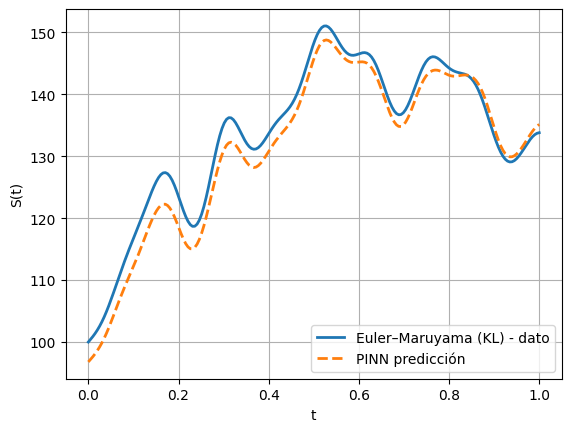

In [17]:
# Nueva realización de ζ no vista en training
sim_test = BlackScholesKL(S0_val, mu_val, sigma_val, T_val, n_terms=n_terms)
data_test_path = sim_test.generate_dataset(N=200)

t_np_path = data_test_path["t"]           # (N_time,)
S_np_path = data_test_path["S"]           # (N_time,)
zetas_np  = data_test_path["zetas"]       # (n_terms,)

# Construimos tensores para esta trayectoria
t_path = torch.tensor(t_np_path, dtype=torch.float32, device=device).view(-1, 1)
z_path = torch.tensor(
    np.tile(zetas_np, (t_np_path.shape[0], 1)),
    dtype=torch.float32,
    device=device
)

with torch.no_grad():
    u_pinn_path = model(t_path, z_path)         # (N_time,1)
    S_pinn_path = S0_t * torch.exp(u_pinn_path) # (N_time,1)

# A numpy
S_pinn_np = S_pinn_path.cpu().numpy().ravel()

# Graficar
plt.figure()
plt.plot(t_np_path, S_np_path, label="Euler–Maruyama (KL) - dato", linewidth=2)
plt.plot(t_np_path, S_pinn_np, "--", label="PINN predicción", linewidth=2)
plt.legend()
plt.xlabel("t")
plt.ylabel("S(t)")
plt.grid(True)
plt.show()


Ahora realizamos una comparación entre PINN física y PINN física más datos

In [18]:
# Parámetros del modelo Black–Scholes
S0_val   = 100.0
mu_val   = 0.05
sigma_val= 0.2
T_val    = 1.0
n_terms  = 20

# Generamos muchas trayectorias (paths) con distintas ζ
N_time   = 200     # puntos de tiempo por trayectoria
N_paths_total = 40 # paths totales

t_all_np, z_all_np, u_all_np = generate_logS_data_from_KL(
    S0_val, mu_val, sigma_val, T_val,
    n_terms=n_terms,
    N_time=N_time,
    N_paths=N_paths_total
)

# Split train / test (por ejemplo 80% / 20%)
N_total = t_all_np.shape[0]
idx = np.random.permutation(N_total)
split = int(0.8 * N_total)

idx_train = idx[:split]
idx_test  = idx[split:]

t_train_np = t_all_np[idx_train]
z_train_np = z_all_np[idx_train]
u_train_np = u_all_np[idx_train]

t_test_np  = t_all_np[idx_test]
z_test_np  = z_all_np[idx_test]
u_test_np  = u_all_np[idx_test]

# A tensores
device = "cuda" if torch.cuda.is_available() else "cpu"

t_train = torch.tensor(t_train_np, dtype=torch.float32, device=device)
z_train = torch.tensor(z_train_np, dtype=torch.float32, device=device)
u_train = torch.tensor(u_train_np, dtype=torch.float32, device=device)

t_test  = torch.tensor(t_test_np,  dtype=torch.float32, device=device)
z_test  = torch.tensor(z_test_np,  dtype=torch.float32, device=device)
u_test  = torch.tensor(u_test_np,  dtype=torch.float32, device=device)


In [19]:
#Sólo física

model_phys = LogSPINN(T_t, n_terms, hidden_dim=128, n_hidden=5).to(device)
opt_phys = torch.optim.Adam(model_phys.parameters(), lr=1e-3)

for epoch in range(1, n_epochs + 1):
    opt_phys.zero_grad()
    loss, loss_pde, loss_ic = pinn_loss_logS(
        model_phys,
        mu_t, sigma_t, T_t,
        n_terms,
        N_colloc=1024,
        N_ic=128,
        device=device
    )
    loss.backward()
    opt_phys.step()

    if epoch % 500 == 0:
        print(f"[PHYS] Epoch {epoch} | total={loss:.3e}")


[PHYS] Epoch 500 | total=6.662e-01
[PHYS] Epoch 1000 | total=4.688e-01
[PHYS] Epoch 1500 | total=2.765e-01
[PHYS] Epoch 2000 | total=1.425e-01
[PHYS] Epoch 2500 | total=9.612e-02
[PHYS] Epoch 3000 | total=6.946e-02
[PHYS] Epoch 3500 | total=4.048e-02
[PHYS] Epoch 4000 | total=2.594e-02
[PHYS] Epoch 4500 | total=2.025e-02
[PHYS] Epoch 5000 | total=2.278e-02


In [20]:
#Física + datos

model_data = LogSPINN(T_t, n_terms, hidden_dim=128, n_hidden=5).to(device)
opt_data = torch.optim.Adam(model_data.parameters(), lr=1e-3)

lambda_data = 1.0

for epoch in range(1, n_epochs + 1):
    opt_data.zero_grad()
    loss, loss_pde, loss_ic, loss_data = pinn_loss_logS_with_data(
        model_data,
        mu_t, sigma_t, T_t,
        n_terms,
        t_data=t_train,
        z_data=z_train,
        u_data=u_train,
        lambda_data=lambda_data,
        N_colloc=1024,
        N_ic=128,
        device=device
    )
    loss.backward()
    opt_data.step()

    if epoch % 500 == 0:
        print(f"[DATA] Epoch {epoch} | total={loss:.3e} | data={loss_data:.3e}")


[DATA] Epoch 500 | total=6.751e-01 | data=1.850e-03
[DATA] Epoch 1000 | total=4.974e-01 | data=1.070e-03
[DATA] Epoch 1500 | total=3.762e-01 | data=8.319e-04
[DATA] Epoch 2000 | total=2.350e-01 | data=6.314e-04
[DATA] Epoch 2500 | total=1.444e-01 | data=2.888e-03
[DATA] Epoch 3000 | total=8.577e-02 | data=1.547e-03
[DATA] Epoch 3500 | total=4.310e-02 | data=4.805e-04
[DATA] Epoch 4000 | total=4.084e-02 | data=1.561e-03
[DATA] Epoch 4500 | total=2.708e-02 | data=5.702e-04
[DATA] Epoch 5000 | total=1.711e-02 | data=1.295e-04


In [21]:
def evaluate_model(model, t_test, z_test, u_test, S0_t):
    model.eval()
    with torch.no_grad():
        u_pred = model(t_test, z_test)
        S_pred = S0_t * torch.exp(u_pred)
        S_true = S0_t * torch.exp(u_test)

        mse_u  = torch.mean((u_pred - u_test)**2).item()
        mae_u  = torch.mean(torch.abs(u_pred - u_test)).item()
        rel_S  = torch.mean(torch.abs(S_pred - S_true) / (S_true + 1e-8)).item()

    return mse_u, mae_u, rel_S


In [22]:
mse_u_phys, mae_u_phys, rel_S_phys = evaluate_model(
    model_phys, t_test, z_test, u_test, S0_t
)

mse_u_data, mae_u_data, rel_S_data = evaluate_model(
    model_data, t_test, z_test, u_test, S0_t
)

print("=== RESULTADOS EN TEST ===")
print(f"Física pura:  MSE_u={mse_u_phys:.3e} | MAE_u={mae_u_phys:.3e} | RelErr_S={rel_S_phys:.3e}")
print(f"Con datos:    MSE_u={mse_u_data:.3e} | MAE_u={mae_u_data:.3e} | RelErr_S={rel_S_data:.3e}")


=== RESULTADOS EN TEST ===
Física pura:  MSE_u=9.420e-04 | MAE_u=2.879e-02 | RelErr_S=2.833e-02
Con datos:    MSE_u=8.804e-05 | MAE_u=7.282e-03 | RelErr_S=7.249e-03


In [23]:
sim_new = BlackScholesKL(S0_val, mu_val, sigma_val, T_val, n_terms=n_terms)
data_new = sim_new.generate_dataset(N=200)

t_new_np = data_new["t"]
S_new_np = data_new["S"]
z_new_np = np.tile(data_new["zetas"], (len(t_new_np), 1))

t_new = torch.tensor(t_new_np, dtype=torch.float32, device=device).view(-1,1)
z_new = torch.tensor(z_new_np, dtype=torch.float32, device=device)


In [24]:
with torch.no_grad():
    u_phys = model_phys(t_new, z_new)
    u_data = model_data(t_new, z_new)

S_phys = S0_t * torch.exp(u_phys)
S_data = S0_t * torch.exp(u_data)


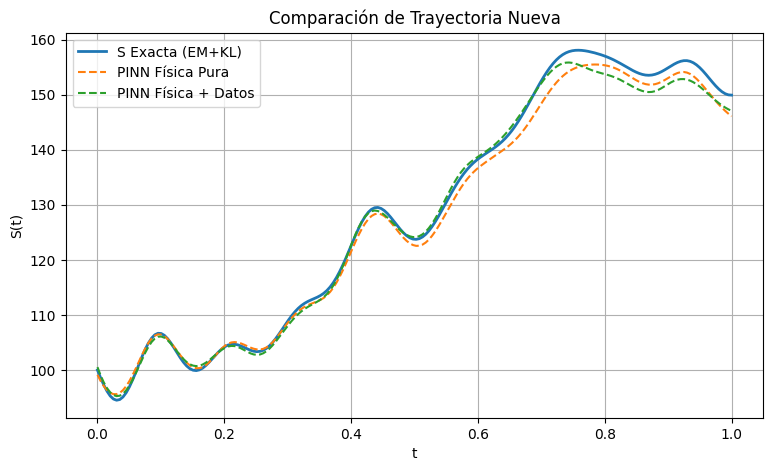

In [ ]:
plt.figure(figsize=(9,5))
plt.plot(t_new_np, S_new_np, label="S Exacta (EM+KL)",
         color='black', linewidth=2, zorder=3)
plt.plot(t_new_np, S_phys.cpu().numpy().ravel(), "--",
         label="PINN Física Pura", color='tab:orange', linewidth=2, zorder=2)
plt.plot(t_new_np, S_data.cpu().numpy().ravel(), "-.",
         label="PINN Física + Datos", color='tab:blue', linewidth=2, zorder=4)
# Opcional: marcar algunos puntos de la trayectoria exacta para resaltar
plt.scatter(t_new_np[::10], S_new_np[::10], color='black', s=20, alpha=0.6, zorder=5)

plt.title("Comparación de Trayectorias")
plt.xlabel("t")
plt.ylabel("S(t)")
plt.grid(True, alpha=0.3)
plt.legend()
plt.show()
